### 1. GAN обучается воспроизводить реальные данные.<br>
Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
● Сгенерировать настоящие данные
● Изменить архитектуру дискриминатора и генератора
● Построить графики

2. (*Усложненное задание) Используя датасет MNIST из урока, построить модели
генератора и дискриминатора в модели DCGAN как описано в оригинальной статье.
И обучите ее на данных MNIST. В качестве помощи, можете воспользоваться
официальной статьей от pytorch.

In [7]:
import os
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython import display
from torchvision.utils import save_image, make_grid

%matplotlib inline

Определим устройство

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Сгенерируем настоящие данные

In [3]:
class Data(Dataset):
    def __init__(self, func, min, max, num):
        self.num = num
        self.x = np.random.rand(num) * (max - min) + min
        self.func = func

    def __getitem__(self, idx):
        point = self.x[idx]
        
        return torch.Tensor([point, self.func(point)])

    def __len__(self):
        return self.num

Проведем данные через заданную функцию $y = \frac{sin(x)}{x} - \frac{x}{10}$

In [4]:
FUNC = lambda x: np.sin(x)/x - x/10

In [5]:
MIN = -15
MAX = 15
NUM = 10000

In [6]:
#получили наш тензор
data = Data(FUNC, MIN, MAX, NUM)
data[0]

tensor([11.7812, -1.2381])

In [8]:
#обернем данные в DataLoader
data_loader = DataLoader(data, batch_size = 1000, shuffle=True)

Подключаем генератор

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()

        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.linear_1(x)
        x = torch.tanh(x)
        x = self.linear_2(x)      
        return x

Подключаем дискриминатор

In [10]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.linear_1 = nn.Linear(2, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear_3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x): 
    
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)
        x = torch.relu(x)
        x = self.linear_3(x)
        x = torch.sigmoid(x)
        return x

Инициализируем и обучим модель

In [13]:
n_epochs = 1000  # количество эпох
lr = 0.01  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 1  # Размерность случайного вектора, который подается на вход генератору
hidden_dim = 64  # Размерность скрытого слоя

In [14]:
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(    
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)   
)

optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# функция ошибки общая
adversarial_loss = torch.nn.BCELoss()

In [15]:
d_loss_history = []
g_loss_history = []

Epoch: 10; Discriminator_loss: 0.675; Generator_loss: 0.728


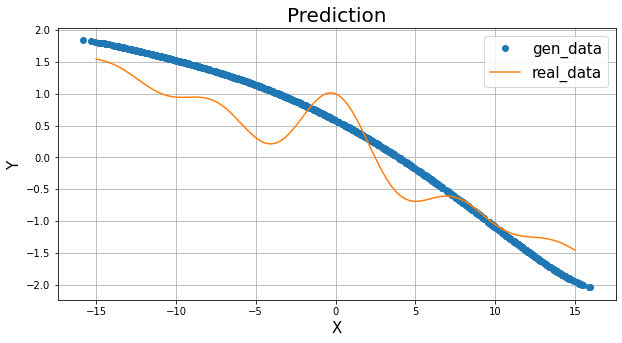

Epoch: 20; Discriminator_loss: 0.619; Generator_loss: 0.906


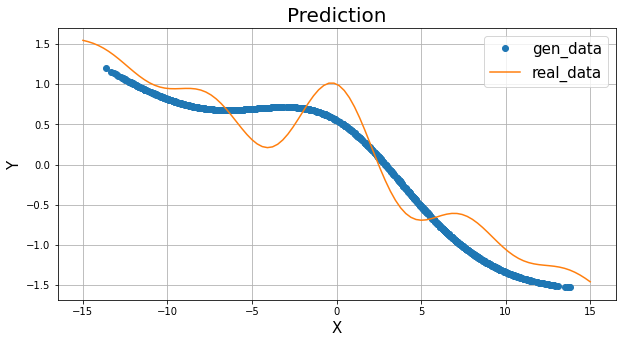

Epoch: 30; Discriminator_loss: 0.638; Generator_loss: 0.829


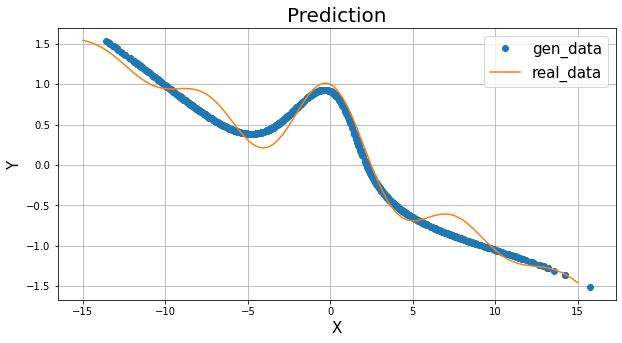

Epoch: 40; Discriminator_loss: 0.668; Generator_loss: 0.789


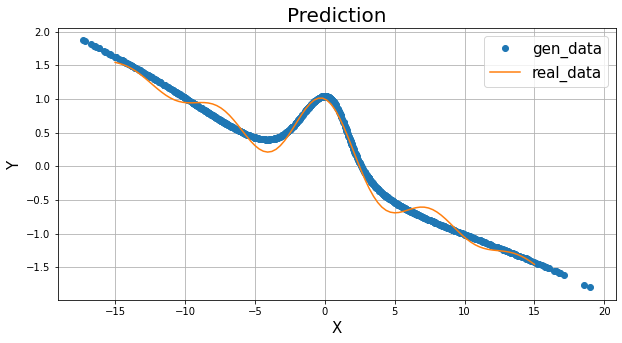

Epoch: 50; Discriminator_loss: 0.659; Generator_loss: 0.788


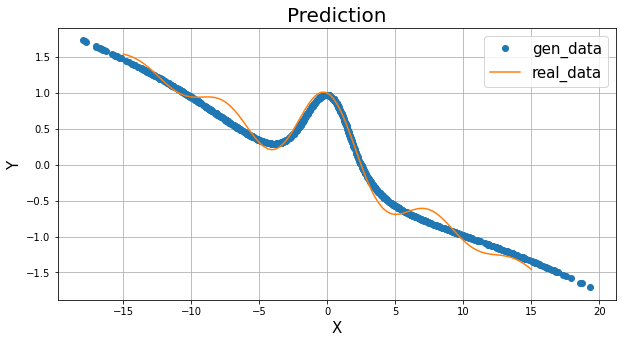

Epoch: 60; Discriminator_loss: 0.656; Generator_loss: 0.83


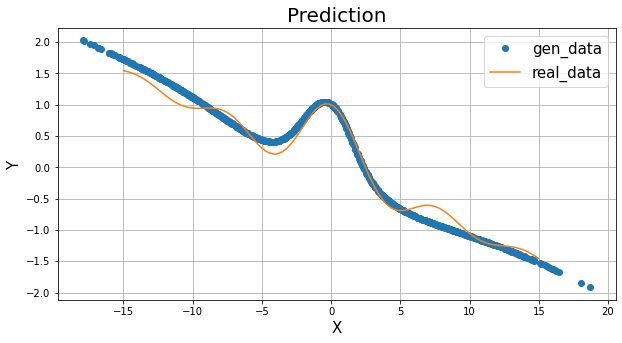

Epoch: 70; Discriminator_loss: 0.659; Generator_loss: 0.843


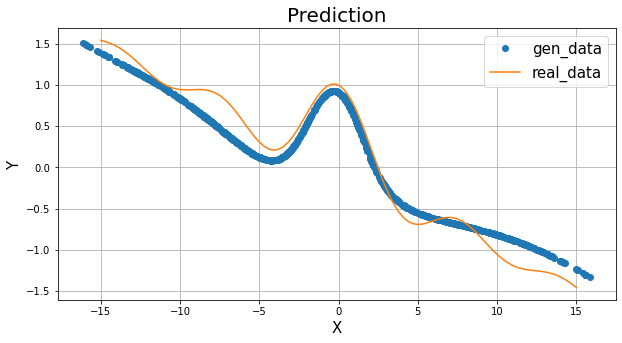

Epoch: 80; Discriminator_loss: 0.652; Generator_loss: 0.812


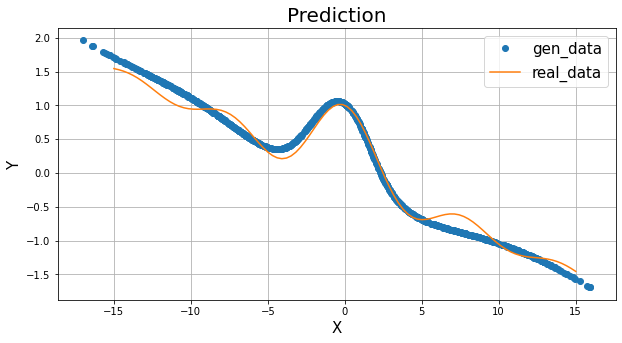

Epoch: 90; Discriminator_loss: 0.651; Generator_loss: 0.846


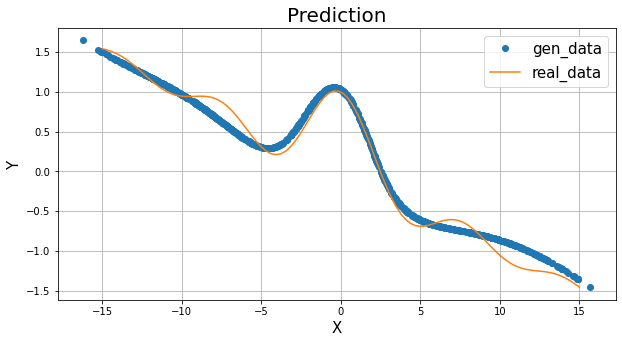

Epoch: 100; Discriminator_loss: 0.658; Generator_loss: 0.833


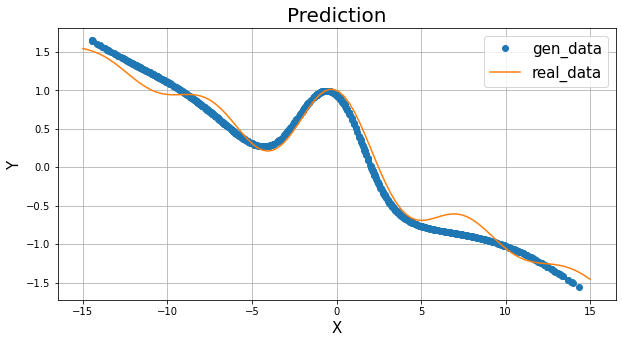

Epoch: 200; Discriminator_loss: 0.607; Generator_loss: 1.171


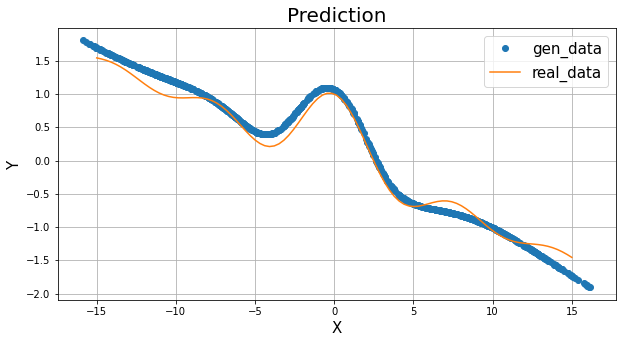

Epoch: 300; Discriminator_loss: 0.563; Generator_loss: 1.32


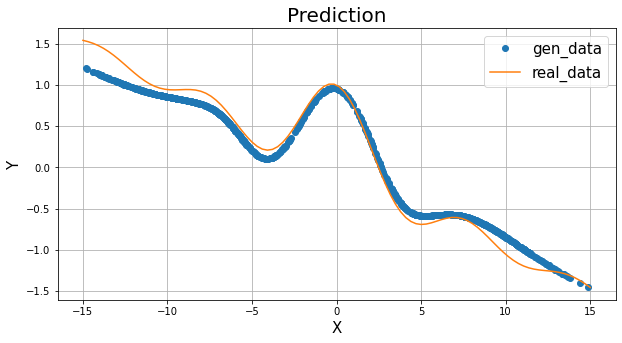

Epoch: 400; Discriminator_loss: 0.588; Generator_loss: 1.147


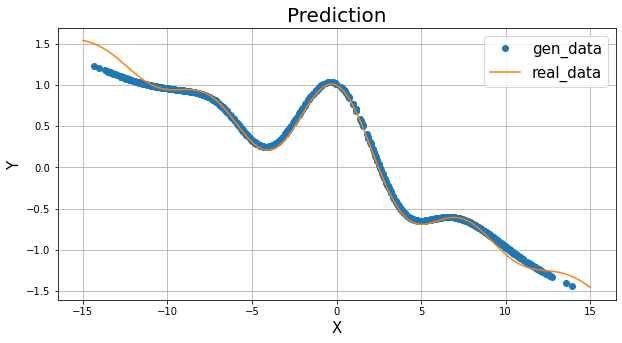

Epoch: 500; Discriminator_loss: 0.585; Generator_loss: 1.13


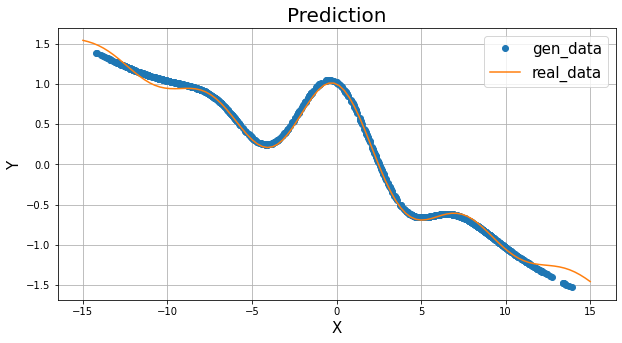

Epoch: 600; Discriminator_loss: 0.593; Generator_loss: 1.236


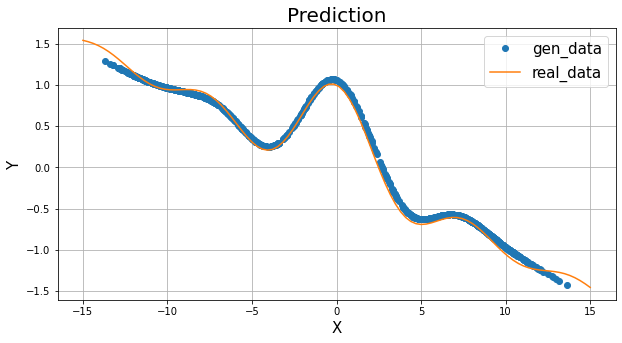

Epoch: 700; Discriminator_loss: 0.572; Generator_loss: 1.172


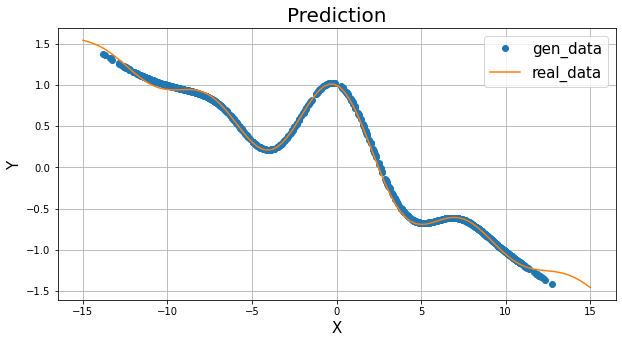

Epoch: 800; Discriminator_loss: 0.565; Generator_loss: 1.26


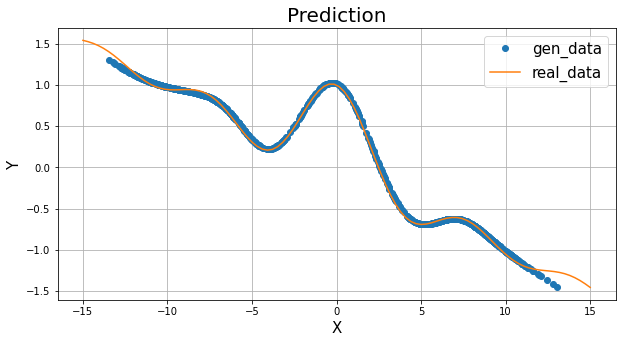

Epoch: 900; Discriminator_loss: 0.541; Generator_loss: 1.499


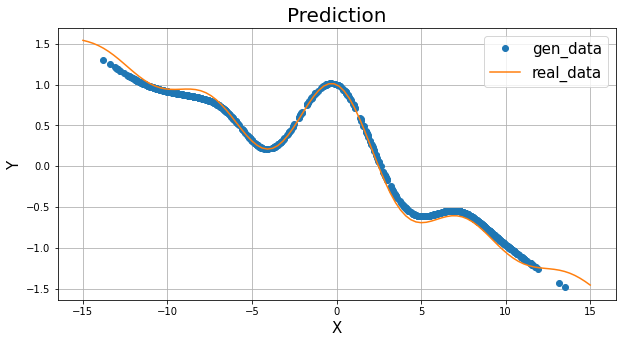

Epoch: 1000; Discriminator_loss: 0.561; Generator_loss: 1.263


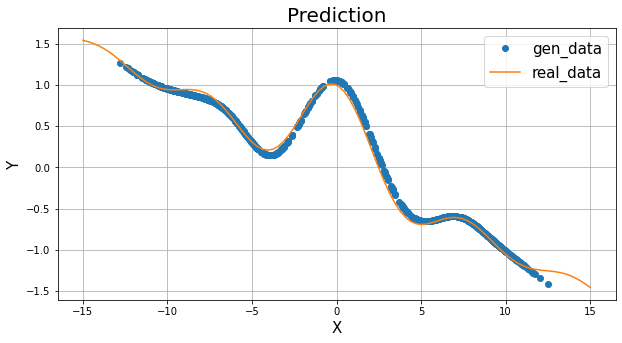

In [19]:
for epoch in range(n_epochs):    

    d_loss_mean = 0.0
    g_loss_mean = 0.0

    for data in data_loader:
        batch_size = len(data)
        
''' Лейблы для данных: 1 - настоящие, 0 - сгенерированные '''
        valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)

        # real_data = data.type(torch.FloatTensor).to(device)
        real_data = data.type(torch.Tensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума        
        gen_data = generator(z)
        
'''Тренировка дискриминатора '''
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # Усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

''' Тренировка генератора'''
        
        # генерация шума
        # z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        d_loss_mean += d_loss.item()
        g_loss_mean += g_loss.item()
        
'''Отображение процесса обучения и вывод функций потерь '''
    if ((epoch + 1) % 10 == 0 and (epoch + 1) < 100)  or ((epoch + 1) % 100) == 0:
        print(f'Epoch: {epoch + 1}; '\
                f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
                f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')
    
        plt.figure(figsize = (10,5))
        plt.title('Prediction', fontsize = 20)
        plt.grid(True)
        plt.ylabel('Y', fontsize = 15)
        plt.xlabel('X', fontsize = 15)

        gen_data = gen_data.cpu().detach().numpy()
        plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')

        plt.plot(np.linspace(MIN, MAX, 100), FUNC(np.linspace(MIN, MAX, 100)), label='real_data')

        plt.legend(fontsize = 15)
        plt.show()
    
    d_loss_history.append(d_loss_mean / len(data_loader))
    g_loss_history.append(g_loss_mean / len(data_loader))       

Процесс обучения модели показал, что на первых 100 эпохах происходило обучение генератора, где он успешно раз за разом воспроизводит срединные точки, однако справиться с крайними точками ему не удается. Вероятно потому что при обучении генератора на вход подавалось нормальное распределение, т.е. генератор гораздо реже ошибается на крайних точках и реже настраивает для них веса, но практически не ошибается на центральной области, которая гораздо ближе к нормальному распределению.



Посмотрим на результат работы генератора и дискриминатора вместе

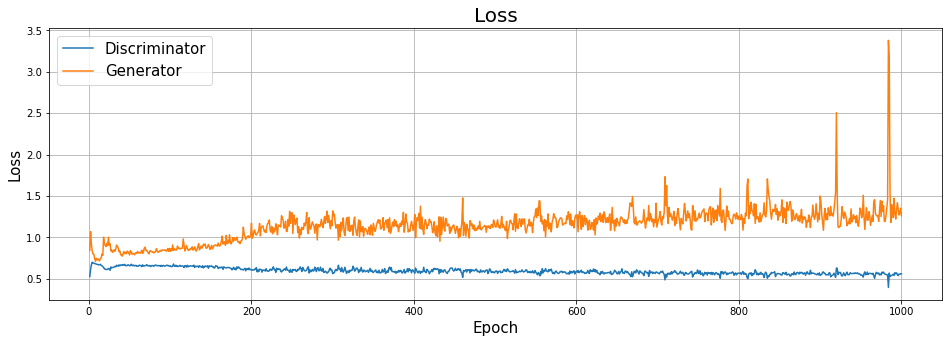

In [21]:
plt.figure(figsize = (16,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, n_epochs+1), d_loss_history, label='Discriminator')
plt.plot(range(1, n_epochs+1), g_loss_history, label='Generator')
plt.legend(fontsize = 15);

В процессе выполнения задания удалось обучить генератор создавать точки, которые будут лежать на графике функции
 $y = \frac{sin(x)}{x} - \frac{x}{10}$